2. iv. Can one use regression to associate CREs with gene expression?

    - a. How much of the variance of gene expression can be explained for each gene with this approach?

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

DATA_DIR = "data/"
DATA_PROC_DIR = "data-processed/"
ATAC_SEQ_PATH = os.path.join(DATA_DIR, "ImmGenATAC18_AllOCRsInfo.csv")
RNA_SEQ_PATH = os.path.join(DATA_DIR, "mmc2.csv")
#REFFLAT_PATH = os.path.join(DATA_DIR, "refFlat.txt.gz")
PROC_PEAKS_PATH = os.path.join(DATA_PROC_DIR, "peaks_annotated.csv")

# --- 1. Load Data ---
# 1.1 CRE annotations (must include 'peak_id' and 'nearest_gene')
peaks = pd.read_csv(PROC_PEAKS_PATH)
#peaks["peak_id"] = peaks.index  # ensure a unique integer ID

# 1.2 ATAC accessibility (peaks × cellTypes)
atac = pd.read_csv(ATAC_SEQ_PATH, index_col=[0,1,2]).drop(columns=["mm10.60way.phastCons_scores", "_-log10_bestPvalue", "Included.in.systematic.analysis"])
atac = atac.select_dtypes(include=[np.number]).dropna(axis=0, how='any')
#atac = atac.mean(axis=1, numeric_only=True)
#atac.index.names = ["chrom","start","end"]

# 1.3 RNA expression (genes × cellTypes)
rna = pd.read_csv(RNA_SEQ_PATH, index_col=0)
#rna = rna.mean(axis=1, numeric_only=True)

In [2]:
# --- 2. Build gene → CRE mapping ---
# We'll use the 'TSS_GeneName' field to link peaks to their gene.
gene_to_peaks = peaks.groupby("TSS_GeneName")["id"].apply(list).to_dict()

# 2.1 Explode the gene lists
#peaks["gene_list"] = peaks["genes.within.100Kb"].str.split(",")
#peaks_exploded = peaks.explode("gene_list").rename(columns={"gene_list":"gene"})
# Drop any empty gene entries
#peaks_exploded = peaks_exploded[peaks_exploded["gene"].notna() & (peaks_exploded["gene"]!="")]

# 2.2 Group to get mapping: gene → list of peak_ids
#gene_to_peaks = peaks_exploded.groupby("gene")["id"].apply(list).to_dict()

# --- 3. Perform regression ---
def perform_regression(atac_data, rna_data):
    """
    Perform linear regression for each gene based on ATAC data.
    
    Parameters:
    - atac_data: DataFrame with ATAC accessibility data (peaks × cellTypes).
    - rna_data: DataFrame with RNA expression data (genes × cellTypes).
    
    Returns:
    - results: DataFrame with regression results for each gene.
      Contains columns: 'gene', 'R2', 'n_CRes'.
    - peak_means: DataFrame with mean values for RNA and ATAC peaks.
    """
    results = []
    peak_means = []
    model = LinearRegression()

    for gene, peak_ids in gene_to_peaks.items():
        # skip if gene not in RNA or too few CREs
        if gene not in rna_data.index or len(peak_ids) < 2:
            continue

        # Build X: shape (n_cellTypes, n_peaks)
        sub = atac_data.loc[peak_ids]  # DataFrame: rows=CREs, cols=cell types

        # DROP any CRE row with NA
        sub_clean = sub.dropna(axis=0, how="any")
        if sub_clean.shape[0] < 2:
            continue

        X = sub_clean.values.T  # transpose → samples × features

        # Build y: expression vector for this gene across same cellTypes
        y = rna_data.loc[gene].values

        peak_means.append({"RNA Peak Strength": y.mean(), "ATAC Peak Strength": X.mean(axis=0)})

        # Fit and record R^2
        try:
            model.fit(X, y)
            r2 = model.score(X, y) # R^2
            beta = model.coef_  # beta coefficient across cell types
        except Exception as e:
            logging.warning(f"Regression failed for {gene}: {e}")
            continue

        results.append({"gene": gene, "R2": r2, "beta": beta, "n_CRes": len(peak_ids)})
    
    print(f"Computed R² for {len(results)} genes.")
    return pd.DataFrame(results).set_index("gene"), pd.DataFrame(peak_means)

In [3]:
# Align to only the intersection of cell types
common_cells = atac.columns.intersection(rna.columns)
if len(common_cells) < len(atac.columns) or len(common_cells) < len(rna.columns):
    print(f"Aligning to {len(common_cells)} common cell types "
          f"(was {len(atac.columns)} ATAC, {len(rna.columns)} RNA)")

results, peak_means_raw = perform_regression(atac[common_cells], rna[common_cells])
peak_means = peak_means_raw.explode("ATAC Peak Strength")

Aligning to 85 common cell types (was 90 ATAC, 86 RNA)
Computed R² for 16145 genes.


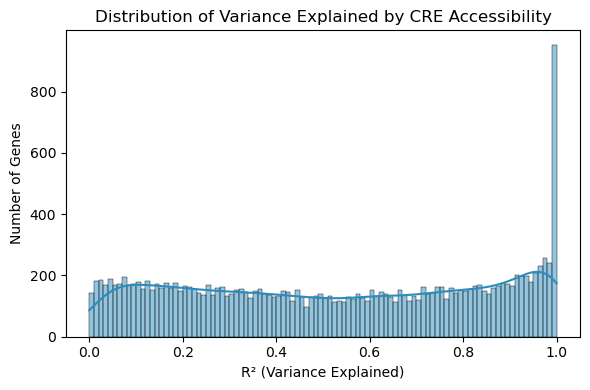

count    16145.000000
mean         0.529621
std          0.316910
min          0.000027
25%          0.240638
50%          0.532936
75%          0.825124
max          1.000000


In [4]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results["R2"], bins=100, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results["R2"].describe().to_string())

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

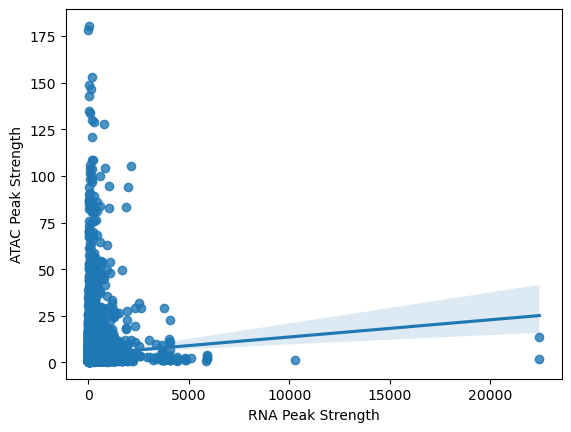

In [5]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means["ATAC Peak Strength"] = peak_means["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(data=peak_means.sample(10000), x="RNA Peak Strength", y="ATAC Peak Strength")

    - b. How do the coefficients differ when it is performed on your cell lineage alone?

In [6]:
ilc_columns = ["NK.27+11b-.BM","NK.27+11b+.BM","NK.27-11b+.BM","NK.27+11b-.Sp","NK.27+11b+.Sp","NK.27-11b+.Sp","ILC2.SI", "ILC3.NKp46-CCR6-.SI", "ILC3.NKp46+.SI", "ILC3.CCR6+.SI"]
results_ilc, peak_means_ilc_raw = perform_regression(atac[ilc_columns], rna[ilc_columns])

peak_means_ilc = peak_means_ilc_raw.explode("ATAC Peak Strength")

Computed R² for 16145 genes.


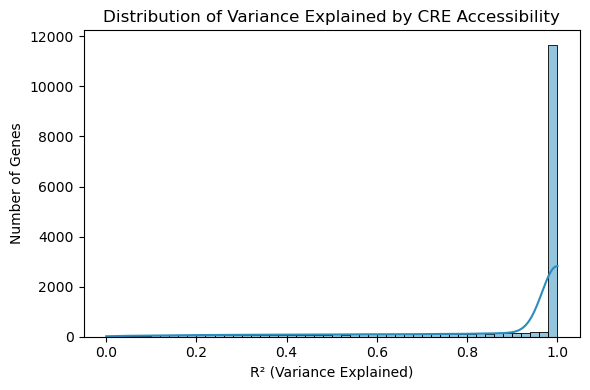

count    16145.000000
mean         0.885997
std          0.232682
min          0.000423
25%          0.927936
50%          1.000000
75%          1.000000
max          1.000000


In [7]:

# --- 5. Plot distribution of R² ---
#sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.histplot(results_ilc["R2"], bins=50, kde=True, color="#2b8cbe")
plt.xlabel("R² (Variance Explained)")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variance Explained by CRE Accessibility")
plt.tight_layout()
#plt.savefig("reports/R2_distribution.png", dpi=300)
plt.show()

# Optional: print summary statistics
print(results_ilc["R2"].describe().to_string())

<Axes: xlabel='RNA Peak Strength', ylabel='ATAC Peak Strength'>

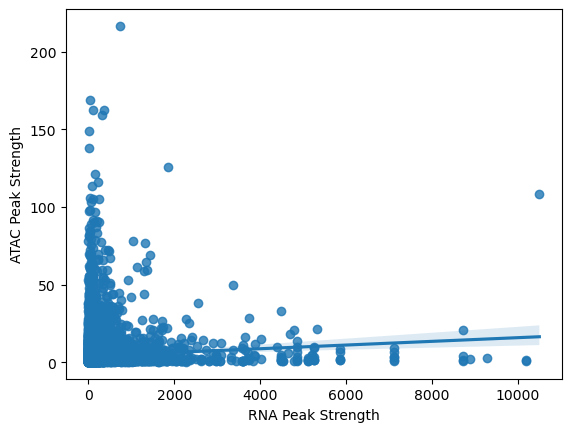

In [8]:
# Ensure "ATAC Peak Strength" is a scalar (mean) for each row
peak_means_ilc["ATAC Peak Strength"] = peak_means_ilc["ATAC Peak Strength"].apply(
	lambda x: np.mean(x) if isinstance(x, (np.ndarray, list)) else x
)

sns.regplot(
	data=peak_means_ilc.sample(10000),
	x="RNA Peak Strength",
	y="ATAC Peak Strength"
)

In [9]:
comp = pd.DataFrame({
    "beta_global": results["beta"],
    "beta_ilc": results_ilc["beta"],
    "beta_diff": results["beta"] - results_ilc["beta"]
})

sns.histplot(comp["beta_diff"].dropna(), bins=2000)
plt.xlim(-20, 20)
plt.title("Distribution of β(Global) − β(ILC)")
plt.xlabel("Coefficient Difference")
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

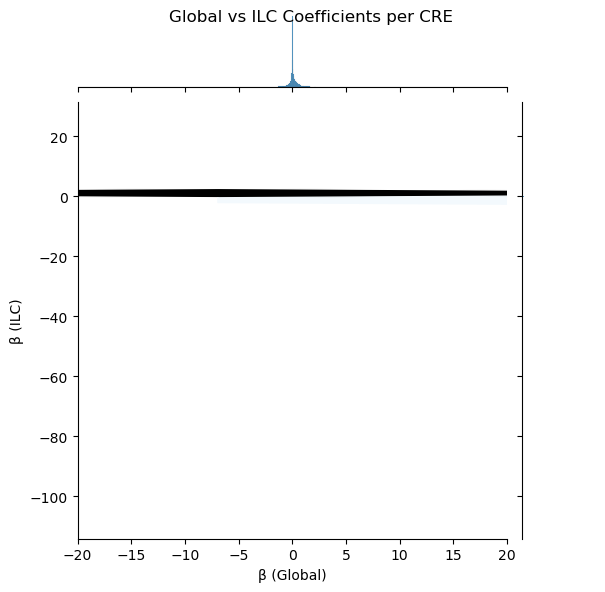

In [ ]:

# 2) Scatter β_global vs β_ilc
sns.jointplot(x="beta_global", y="beta_ilc", data=comp, kind="hex", gridsize=50, xlim=(-20, 20))
plt.xlabel("β (Global)")
plt.ylabel("β (ILC)")
plt.suptitle("Global vs ILC Coefficients per CRE")
plt.show()


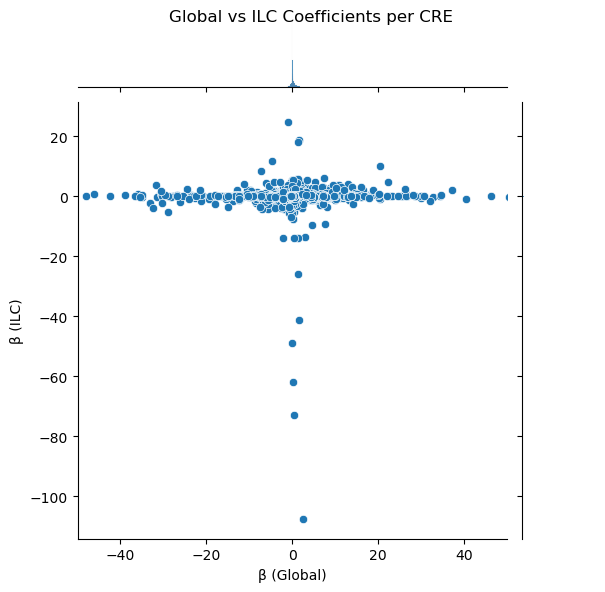

In [ ]:

sns.jointplot(x="beta_global", y="beta_ilc", data=comp, xlim=(-50,50))
plt.xlabel("β (Global)")
plt.ylabel("β (ILC)")
plt.suptitle("Global vs ILC Coefficients per CRE")
plt.show()

In [ ]:
test_data = peak_means_raw.sample(10000)

# Find the most common length of ATAC Peak Strength lists
lengths = test_data["ATAC Peak Strength"].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else np.nan)
common_length = lengths.value_counts().idxmax()

# Filter to only rows with the most common length
filtered = test_data[lengths == common_length]

# Convert the column of lists to a 2D numpy array
X = np.stack(filtered["ATAC Peak Strength"].values)
y = filtered["RNA Peak Strength"].values

model = LinearRegression()
model.fit(X, y)
R2 = model.score(X, y)
print(f"R² for test data: {R2:.4f}")
beta = model.coef_
print(f"β coefficient (mean across features): {np.mean(beta):.4f}")

R² for test data: 0.4615
β coefficient (mean across features): 0.4381


array([-12.7851916 ,   0.77218556,   3.15762251,  -6.4309275 ,
        -0.27824521,  -1.64868254,  -3.30893896,   0.97132253,
         3.98640516,  -4.30279635,   1.43883575,   4.00446954,
         6.37186748, -15.57846449,   0.8034125 ,  -1.95853452,
         2.97663672,   4.00526389,  -0.98576533,  -0.79179105,
         3.57916638,  -3.73763583,   1.02664985,  -0.34786395,
        11.76897685,  -3.13059292,   5.36943291,   0.83989824,
        -0.71846473,   0.9818024 ,  -1.16962714,  -1.10561768,
         1.9703509 ,   2.00839593,  -4.52822188,   3.64178317,
         5.10800288,  -0.10102811,  -0.18901299,   1.13068079,
        -3.23563891,  -3.09806484,  26.21830097,  -2.8263764 ,
         5.77031992,  -4.72490925,   4.74702534,  -2.03747614,
         1.63214136,  -0.55109586,   2.07806189,  -0.89532949,
        -7.79208639,   1.07827085,  -2.27778585,   3.82632365,
         3.51558657,  -3.84860658,   0.35412363,  11.60560614,
        -2.62718461,   0.82768411,  -2.33773148,   3.94

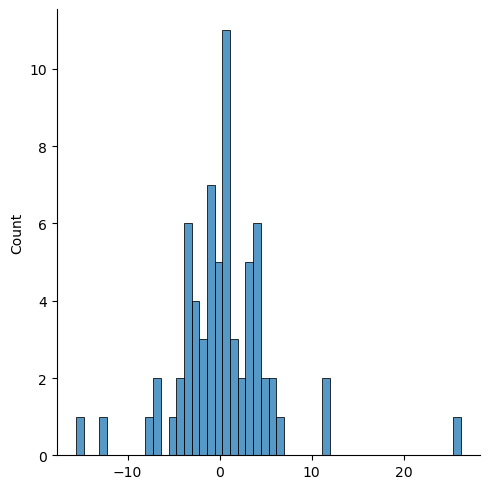

In [ ]:
sns.displot(beta, bins=50)
beta